In [16]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']

In [17]:
# read data
data = pd.read_csv("data/com.csv")
data.head()

,bianh,com_name,com_addr,cat,se_cat,com_des,born_data,death_data,live_days,financing,...,death_reason,invest_name,ceo_name,ceo_des,ceo_per_des,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,1,麦子金服,上海,金融,借贷,麦子金服是一家移动互联网金融服务集团，为个人和企业提供包括财富管理、股权投资、投融资咨询等综...,2015-03-01,2019-11-25,1730,B轮,...,政策监管 法律法规风险,海通开元&中缔资本,黄大容,董事长,黄大容，80后，经济学硕士，精通中英德三国语言。连续创业者，23岁创立第一家公司，25岁涉足...,NaN,NaN,NaN,NaN,NaN
1,1,拓道金服,浙江,金融,借贷,拓道金服是一家专注于汽车抵押贷款这一细分市场的P2P互联网金融公司。拓道金服通过互联网民间的...,2013-11-01,2019-11-24,2214,A轮,...,政策监管 法律法规风险,蓝山中国资本&帮实资本&宏桥资本,张罗军,创始人,杭州拓道科技有限公司执行董事兼总经理，重庆邮电学院计算机专业，创立杭州仁润科技有限公司，具有...,NaN,NaN,NaN,NaN,NaN
2,1,云柏科技,广东,医疗健康,医疗器械及硬件,云柏科技是一家智能健康检测腕表研发商，专注于智能可穿戴设备领域。主要产品包括可穿戴式多功能云...,2014-09-01,2019-11-01,1887,尚未获投,...,行业竞争,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,迷你生鲜,福建,电子商务,生鲜食品,迷你生鲜是一家会员制水果生鲜电商网站，平台产品由基地直供，采购深入全国及东南亚各地区，减少中...,2017-11-01,2019-10-29,727,尚未获投,...,现金流断裂 行业竞争,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,一生健康,北京,医疗健康,寻医诊疗,微爱康一款基于移动互联网的癌症患者互助型垂直社区产品，通过在线社会化问答和类轻博客交流模式，...,2015-01-01,2019-10-17,1750,尚未获投,...,政策监管 法律法规风险,NaN,张耀斌,CEO,张耀斌，为一生（北京）健康科技有限公司的创始人。,NaN,NaN,NaN,NaN,NaN


### 2.data visualization
#### 2.1 regional distribution of death companies

In [18]:
from pyecharts import options as opts
from pyecharts.charts import Map

data["com_addr"] = data["com_addr"].apply(lambda x: x.strip())
s = data.groupby("com_addr").size()

c = (Map()
     .add("Number of dead companies", [*s.items()], "china")
     .set_global_opts(
         title_opts=opts.TitleOpts("Regional distribution"),
         visualmap_opts=opts.VisualMapOpts(max_=200)
     ))
c.render_notebook()

#### 2.2 Industry ranking TOP10

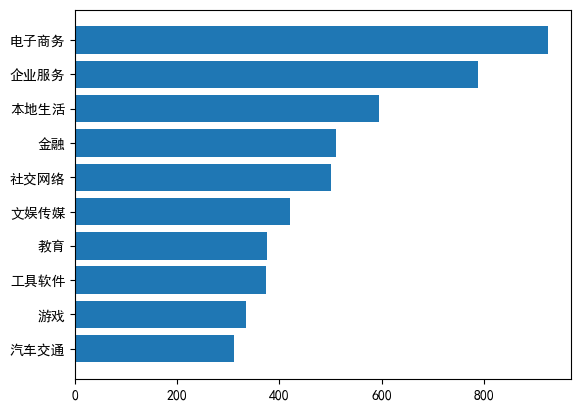

In [19]:
cat_top10 = data.groupby("cat").size().sort_values(ascending=False)[:10].sort_values(ascending=True)
cat_values = cat_top10.values.tolist()
cat_indices = np.arange(len(cat_values))
cat_labels = cat_top10.index.tolist()

plt.barh(cat_indices, width=cat_values)
plt.yticks(cat_indices, cat_labels)
plt.show()

#### 2.3 Segments Top20

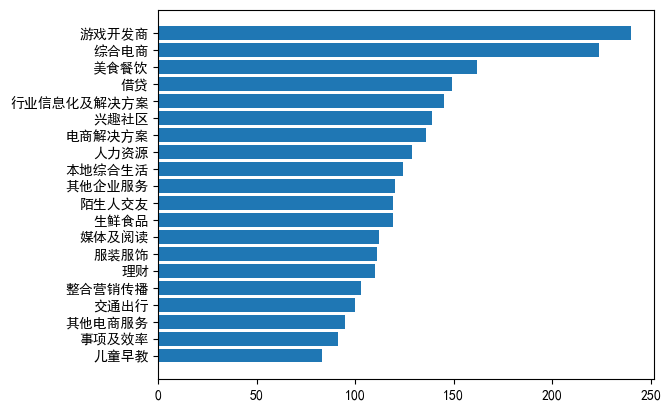

In [20]:
se_cat_top20 = data.groupby('se_cat').size().sort_values(ascending=False)[:20].sort_values(ascending=True)
se_cat_values = se_cat_top20.values.tolist()
se_cat_indices = np.arange(len(se_cat_values))
se_cat_labels = se_cat_top20.index.tolist()

plt.barh(se_cat_indices, width=se_cat_values)
plt.yticks(se_cat_indices, se_cat_labels)
plt.show()

#### 2.4 Year distribution

([<matplotlib.patches.Wedge at 0x22463a4eec0>,
 [Text(1.0432647489218303, 0.3487099993649028, '1-2年'),
  Text(0.8586387676904005, 0.6875605185139055, '10年以上'),
  Text(-0.28008579924265753, 1.0637443043620032, '2-3年'),
  Text(-1.0276738543278374, -0.39228363352422324, '3-4年'),
  Text(-0.18968652834194197, -1.0835215830640301, '4-5年'),
  Text(0.8719053802736935, -0.6706571462750444, '5-10年'),
  Text(1.0997205775133647, -0.024792163957022512, '不到1年')])

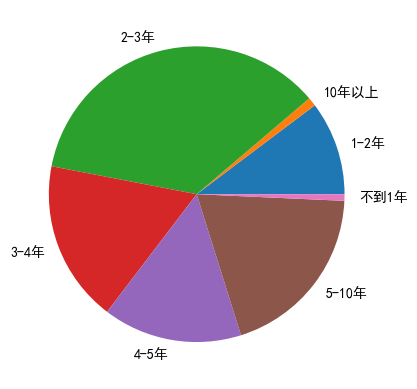

In [21]:
def live_year(x):
    if x < 365:
        return "不到1年"
    if x < 365 * 2:
        return '1-2年'
    if x < 365 * 3:
        return '2-3年'
    if x < 365 * 4:
        return '3-4年'
    if x < 365 * 5:
        return '4-5年'
    if x < 365 * 10:
        return '5-10年'
    return '10年以上'

live_years = data.groupby(data["live_days"].apply(lambda x: live_year(x))).size()

fig, ax = plt.subplots()
ax.pie(live_years.values.tolist(), labels=live_years.index.tolist())

#### 2.4 Closure reason word cloud

In [22]:
death_reason = []
for row in data["death_reason"].values:
    if not pd.isnull(row):
        for name in row.split(" "):
            death_reason.append(name)       
            
reason_text = " ".join(death_reason)

wc = WordCloud(font_path="msyh.ttc",
                         width = 1000,
                         height = 700,
                         background_color='white',
                         max_words=100)
wc.generate(reason_text)
wc.to_file('wordcloud.jpg')